In [1]:
# Cellule 1 : Importations et configuration initiale
import cv2
import numpy as np
from PIL import Image, ImageDraw
import dlib
import matplotlib.pyplot as plt
import os
import glob
import json
import re
import torchvision.transforms as TF
import torch

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Base directories
base_input_dir = "/work/com-304/IAY_neurons_u2/dataset/keyframes"
base_json_dir = "/work/com-304/IAY_neurons_u2/dataset/dataset_unprocessed/openpose_output/json"
base_output_dir = "/work/com-304/IAY_neurons_u2/dataset/processing_256x256"
os.makedirs(base_output_dir, exist_ok=True)

print("✅ Configuration initiale terminée")

✅ Configuration initiale terminée


In [2]:
# Cellule 2 : Définition de la fonction pour améliorer les keypoints (rgb_keyframes)
def enhance_keypoint_image(img, keypoints_data, height=256, width=256):
    """Enhance the original keypoint image with JSON coordinates for hands and face only."""
    img_enhanced = img.convert('RGBA')
    draw = ImageDraw.Draw(img_enhanced)
    
    hand_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4),  # Thumb
        (0, 5), (5, 6), (6, 7), (7, 8),  # Index
        (0, 9), (9, 10), (10, 11), (11, 12),  # Middle
        (0, 13), (13, 14), (14, 15), (15, 16),  # Ring
        (0, 17), (17, 18), (18, 19), (19, 20)  # Pinky
    ]
    
    def scale_coords(coords):
        return int(coords[0] * width / 1280), int(coords[1] * height / 720)
    
    face_keypoints = keypoints_data.get('face_keypoints_2d', [])
    hand_left_keypoints = keypoints_data.get('hand_left_keypoints_2d', [])
    hand_right_keypoints = keypoints_data.get('hand_right_keypoints_2d', [])
    
    for hand_keypoints, color in [(hand_left_keypoints, 'blue'), (hand_right_keypoints, 'blue')]:
        for i in range(0, len(hand_keypoints), 3):
            if i + 2 < len(hand_keypoints) and hand_keypoints[i + 2] > 0:
                x, y = scale_coords(hand_keypoints[i:i+2])
                if 0 <= x < width and 0 <= y < height:
                    draw.ellipse([x-1, y-1, x+1, y+1], fill=color)
        for start, end in hand_connections:
            if start * 3 + 2 < len(hand_keypoints) and end * 3 + 2 < len(hand_keypoints):
                if hand_keypoints[start * 3 + 2] > 0 and hand_keypoints[end * 3 + 2] > 0:
                    x1, y1 = scale_coords(hand_keypoints[start * 3:start * 3 + 2])
                    x2, y2 = scale_coords(hand_keypoints[end * 3:end * 3 + 2])
                    if 0 <= x1 < width and 0 <= y1 < height and 0 <= x2 < width and 0 <= y2 < height:
                        draw.line([x1, y1, x2, y2], fill=color, width=10)
    
    for i in range(0, len(face_keypoints), 3):
        if i + 2 < len(face_keypoints) and face_keypoints[i + 2] > 0:
            x, y = scale_coords(face_keypoints[i:i+2])
            if 0 <= x < width and 0 <= y < height:
                draw.ellipse([x-1.5, y-1.7, x+1.7, y+1.7], fill='green')
    
    return img_enhanced.convert('RGB')

print("✅ Fonction enhance_keypoint_image définie")

✅ Fonction enhance_keypoint_image définie


✅ Found 17 pose frames

Processing pose frame: /work/com-304/IAY_neurons_u2/dataset/keyframes/_0fO5ETSwyg_0-5-rgb_front/pose_keyframes/keyframe_11_idx67.jpg...
Image loaded: 720x1280
Crop coordinates: (372, 77, 900, 570)
✅ Saved: /work/com-304/IAY_neurons_u2/dataset/processing_256x256/_0fO5ETSwyg_0-5-rgb_front/pose_keyframes/processed_keyframe_11_idx67.jpg

Processing pose frame: /work/com-304/IAY_neurons_u2/dataset/keyframes/_0fO5ETSwyg_0-5-rgb_front/pose_keyframes/keyframe_04_idx23.jpg...
Image loaded: 720x1280
Crop coordinates: (372, 77, 900, 570)
✅ Saved: /work/com-304/IAY_neurons_u2/dataset/processing_256x256/_0fO5ETSwyg_0-5-rgb_front/pose_keyframes/processed_keyframe_04_idx23.jpg

Processing pose frame: /work/com-304/IAY_neurons_u2/dataset/keyframes/_0fO5ETSwyg_0-5-rgb_front/pose_keyframes/keyframe_01_idx3.jpg...
Image loaded: 720x1280
Crop coordinates: (372, 77, 900, 570)
✅ Saved: /work/com-304/IAY_neurons_u2/dataset/processing_256x256/_0fO5ETSwyg_0-5-rgb_front/pose_keyframes/pr

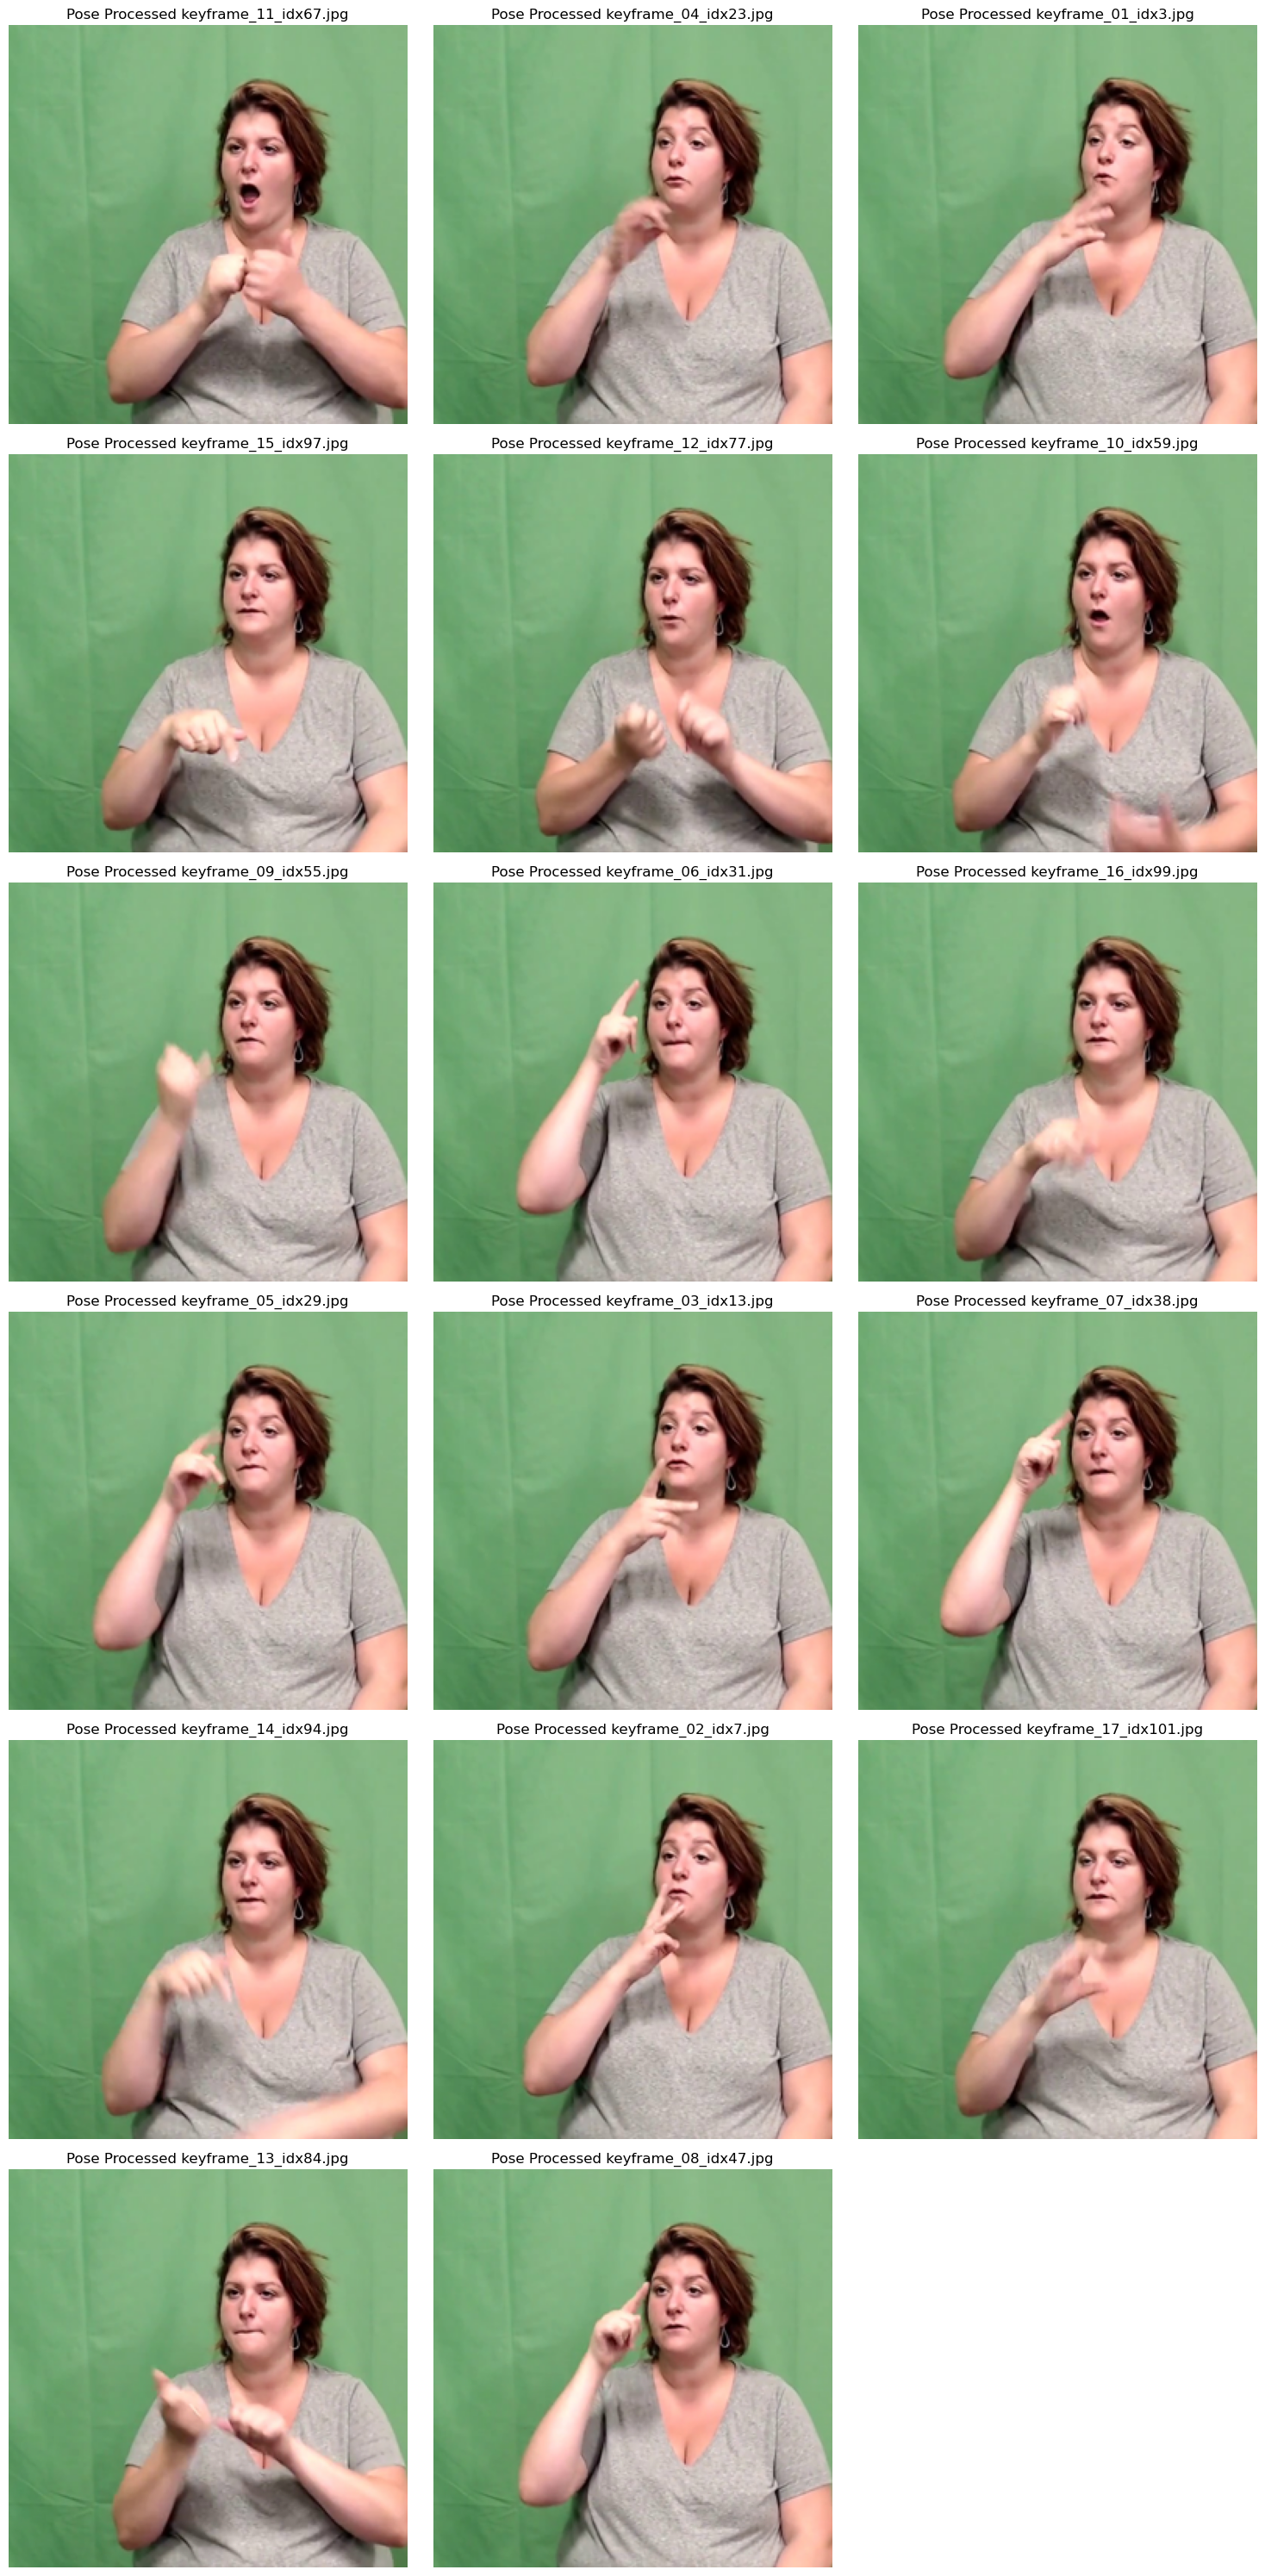

✅ Processed 17 pose images


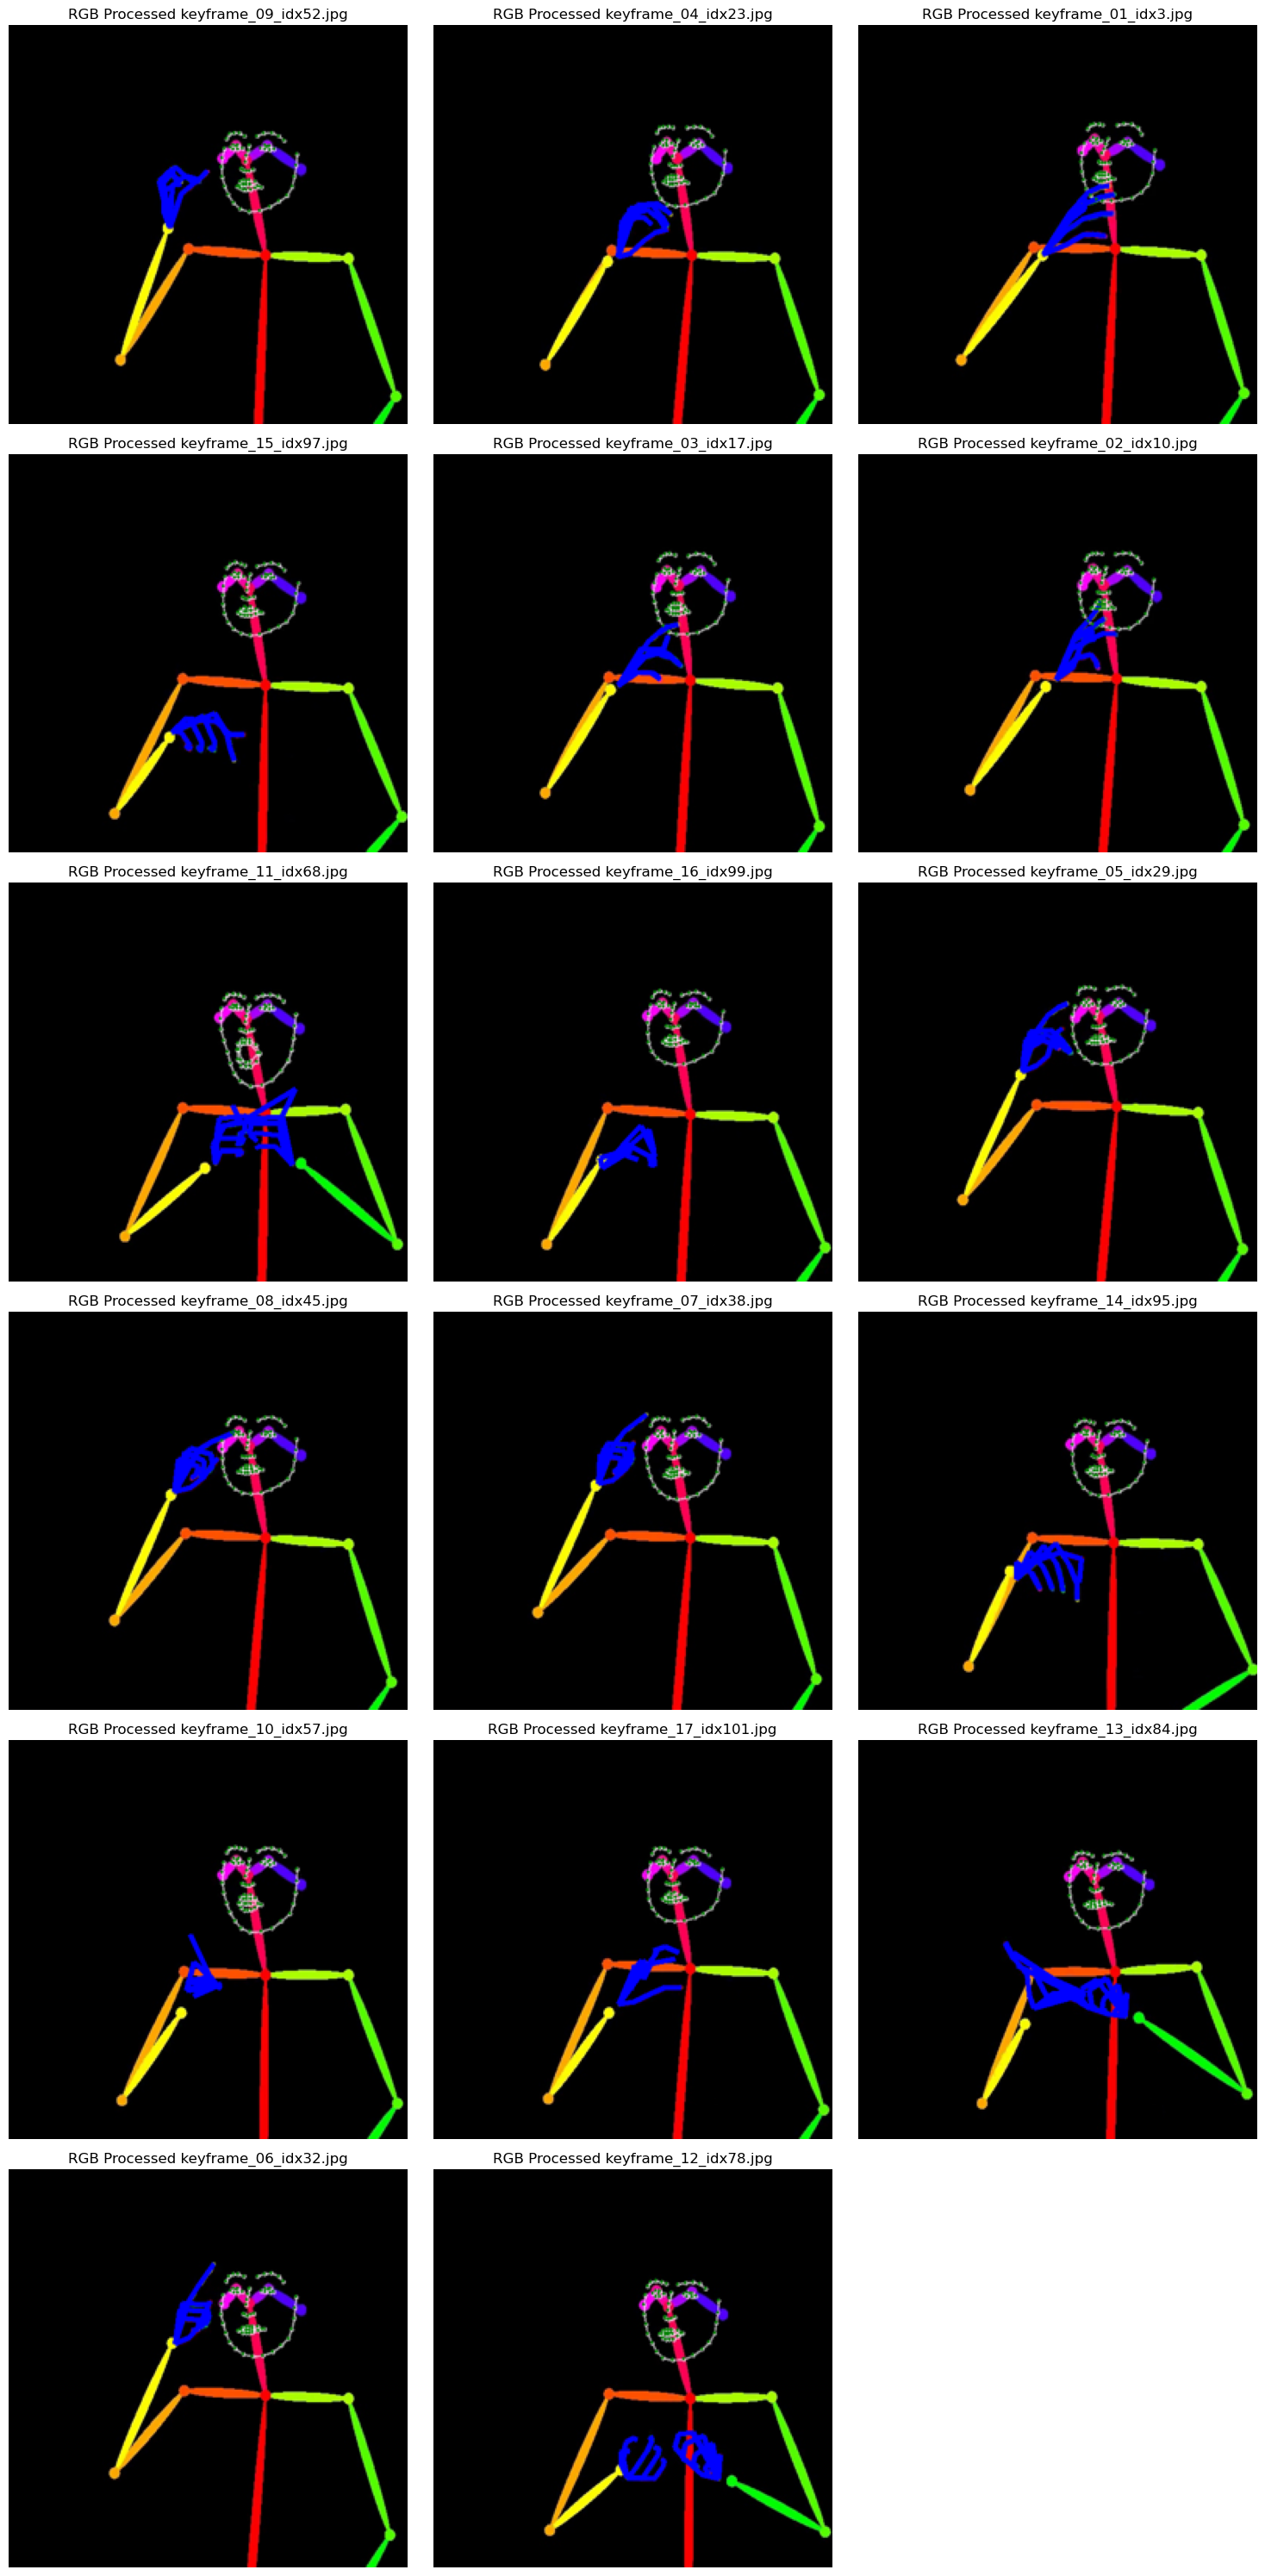

✅ Processed 17 rgb images


In [19]:
# Cellule 3 : Traitement d'un exemple unique avec affichage (mis à jour pour rgb_keyframes)
# Sample directory
sample_dir = "/work/com-304/IAY_neurons_u2/dataset/keyframes/_0fO5ETSwyg_0-5-rgb_front"
json_dir = "/work/com-304/IAY_neurons_u2/dataset/dataset_unprocessed/openpose_output/json/_0fO5ETSwyg_0-5-rgb_front"
rgb_dir = os.path.join(sample_dir, "rgb_keyframes")
pose_dir = os.path.join(sample_dir, "pose_keyframes")

# Output directories for this sample
output_rgb_dir = os.path.join(base_output_dir, os.path.basename(sample_dir), "rgb_keyframes")
output_pose_dir = os.path.join(base_output_dir, os.path.basename(sample_dir), "pose_keyframes")
os.makedirs(output_rgb_dir, exist_ok=True)
os.makedirs(output_pose_dir, exist_ok=True)

# Process pose_keyframes (RGB frames)
image_paths_pose = glob.glob(os.path.join(pose_dir, "*.jpg"))
if not image_paths_pose:
    print(f"❌ No .jpg files found in {pose_dir}")
    image_paths_pose = glob.glob(os.path.join(pose_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(pose_dir, '*.[jJ][pP][gG]'))
print(f"✅ Found {len(image_paths_pose)} pose frames")

processed_pose_images = []
for img_path in image_paths_pose:
    print(f"\nProcessing pose frame: {img_path}...")
    filename = os.path.basename(img_path)
    output_path = os.path.join(output_pose_dir, f"processed_{filename}")

    try:
        original_img = Image.open(img_path).convert('RGB')
        img_np = np.array(original_img)
        h, w, _ = img_np.shape
        print(f"Image loaded: {h}x{w}")
        
        xmin = 372
        xmax = 900
        ymin = 77
        ymax = 570
        print(f"Crop coordinates: ({xmin}, {ymin}, {xmax}, {ymax})")

        cropped_img_np = img_np[ymin:ymax, xmin:xmax]
        if cropped_img_np.size == 0:
            print("❌ Cropped image is empty")
            continue
        cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
        cropped_img.save(output_path)
        processed_pose_images.append((cropped_img, filename))
        print(f"✅ Saved: {output_path}")
    except Exception as e:
        print(f"❌ Error processing {img_path}: {e}")
        continue

# Process rgb_keyframes (human pose frames with enhancement on original image)
image_paths_rgb = glob.glob(os.path.join(rgb_dir, "*.jpg"))
if not image_paths_rgb:
    print(f"❌ No .jpg files found in {rgb_dir}")
    image_paths_rgb = glob.glob(os.path.join(rgb_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(rgb_dir, '*.[jJ][pP][gG]'))
print(f"✅ Found {len(image_paths_rgb)} rgb frames")

json_files = sorted(glob.glob(os.path.join(json_dir, "*.json")))
json_indices = {int(re.search(r'_(\d{12})_keypoints\.json', os.path.basename(json_path)).group(1)): json_path for json_path in json_files}

processed_rgb_images = []
for img_path in image_paths_rgb:
    print(f"\nProcessing rgb frame: {img_path}...")
    filename = os.path.basename(img_path)
    match = re.search(r'keyframe_\d{2}_idx(\d+)\.jpg', filename)
    if match:
        img_index = int(match.group(1))
        json_path = json_indices.get(img_index)
        if json_path:
            with open(json_path, 'r') as f:
                data = json.load(f)
            person = data['people'][0] if data['people'] else None
            if person:
                # Load original image without resizing
                original_img = Image.open(img_path).convert('RGB')
                # Apply enhancement on original image
                img_enhanced = enhance_keypoint_image(original_img, person, height=original_img.height, width=original_img.width)
                img_np = np.array(img_enhanced)
                h, w, _ = img_np.shape
                print(f"Image loaded: {h}x{w}")

                
                xmin = 372
                xmax = 900
                ymin = 77
                ymax = 570
                print(f"Crop coordinates: ({xmin}, {ymin}, {xmax}, {ymax})")

                cropped_img_np = img_np[ymin:ymax, xmin:xmax]
                if cropped_img_np.size == 0:
                    print("❌ Cropped image is empty")
                    continue
                cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
                output_path = os.path.join(output_rgb_dir, f"processed_{filename}")
                cropped_img.save(output_path)
                processed_rgb_images.append((cropped_img, filename))
                print(f"✅ Saved: {output_path}")
            else:
                print(f"❌ No person data in {json_path}")
        else:
            print(f"❌ No matching JSON for index {img_index}")
    else:
        print(f"❌ Invalid filename format: {filename}")

# Display results
if processed_pose_images:
    plt.figure(figsize=(15, 5 * ((len(processed_pose_images) + 2) // 3)))
    for i, (img, filename) in enumerate(processed_pose_images, 1):
        plt.subplot((len(processed_pose_images) + 2) // 3, 3, i)
        plt.imshow(img)
        plt.title(f"Pose Processed {filename}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"✅ Processed {len(processed_pose_images)} pose images")

if processed_rgb_images:
    plt.figure(figsize=(15, 5 * ((len(processed_rgb_images) + 2) // 3)))
    for i, (img, filename) in enumerate(processed_rgb_images, 1):
        plt.subplot((len(processed_rgb_images) + 2) // 3, 3, i)
        plt.imshow(img)
        plt.title(f"RGB Processed {filename}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    print(f"✅ Processed {len(processed_rgb_images)} rgb images")

In [20]:
%cd /work/com-304/IAY_neurons_u2/dataset/processing_256x256/_0fO5ETSwyg_0-5-rgb_front/rgb_keyframes/

/work/com-304/IAY_neurons_u2/dataset/processing_256x256/_0fO5ETSwyg_0-5-rgb_front/rgb_keyframes


In [28]:
%cd notebooks

/home/ihammami/COM-304-FM/com-304-FM-project/nano4M/notebooks


In [29]:
!ls 

 assets					     new_dataset_process.ipynb
 COM304_FM_part1_nanoGPT.ipynb		     poses
 COM304_FM_part2_nanoMaskGIT.ipynb	     poses.zip
 COM304_FM_part3_nano4M.ipynb		    'processed_images(1).zip'
'cosmos_tokenization_of_ the_videos.ipynb'   processed_images.zip
 cosmos.yml				     processed_output
 data-.yml				     rgb1.yaml
 data.yml				     rgb.yaml
 extracted				     script1.py
 extractedv				     script2.py
 keyframe_01_idx3.jpg			     some_example
 keyframe_01_idx3_v3.jpg		     some_example.zip
 keyframe_12_idx77_enhanced.jpg		     tok11.py
 keyframe_12_idx77_enhanced_v2.jpg	     tok123.py
 keyframe_12_idx77_v3.jpg		     tokenize_missing_samples.py
 keyframe_12_idx77_v4.jpg		     tok.py
 keyframe_12_idx77_v6.jpg		     tok-vn.py
 keyframe_13_idx84_v3.jpg


In [20]:
# Cellule 4 : Scaling sur tout le dataset
sample_dirs = [d for d in glob.glob(os.path.join(base_input_dir, "*")) if os.path.isdir(d)]
for sample_dir in sample_dirs:
    print(f"\nProcessing sample: {os.path.basename(sample_dir)}")
    json_dir = os.path.join(base_json_dir, os.path.basename(sample_dir))
    rgb_dir = os.path.join(sample_dir, "rgb_keyframes")
    pose_dir = os.path.join(sample_dir, "pose_keyframes")

    # Output directories
    output_rgb_dir = os.path.join(base_output_dir, os.path.basename(sample_dir), "rgb_keyframes")
    output_pose_dir = os.path.join(base_output_dir, os.path.basename(sample_dir), "pose_keyframes")
    os.makedirs(output_rgb_dir, exist_ok=True)
    os.makedirs(output_pose_dir, exist_ok=True)

    # Process pose_keyframes
    image_paths_pose = glob.glob(os.path.join(pose_dir, "*.jpg"))
    if not image_paths_pose:
        print(f"❌ No .jpg files found in {pose_dir}")
        image_paths_pose = glob.glob(os.path.join(pose_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(pose_dir, '*.[jJ][pP][gG]'))
    #print(f"✅ Found {len(image_paths_pose)} pose frames")

    detector = dlib.get_frontal_face_detector()
    processed_pose_images = []
    for img_path in image_paths_pose:
        #print(f"\nProcessing pose frame: {img_path}...")
        filename = os.path.basename(img_path)
        output_path = os.path.join(output_pose_dir, f"processed_{filename}")

        try:
            original_img = Image.open(img_path).convert('RGB')
            img_np = np.array(original_img)
            h, w, _ = img_np.shape
            #print(f"Image loaded: {h}x{w}")
            xmin = 372
            xmax = 900
            ymin = 77
            ymax = 570
            cropped_img_np = img_np[ymin:ymax, xmin:xmax]
            if cropped_img_np.size == 0:
                print("❌ Cropped image is empty")
                continue
            cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
            cropped_img.save(output_path)
            processed_pose_images.append((cropped_img, filename))
            #print(f"✅ Saved: {output_path}")
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")
            continue

    # Process rgb_keyframes
    image_paths_rgb = glob.glob(os.path.join(rgb_dir, "*.jpg"))
    if not image_paths_rgb:
        print(f"❌ No .jpg files found in {rgb_dir}")
        image_paths_rgb = glob.glob(os.path.join(rgb_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(rgb_dir, '*.[jJ][pP][gG]'))
    #print(f"✅ Found {len(image_paths_rgb)} rgb frames")

    json_files = sorted(glob.glob(os.path.join(json_dir, "*.json")))
    json_indices = {int(re.search(r'_(\d{12})_keypoints\.json', os.path.basename(json_path)).group(1)): json_path for json_path in json_files}

    processed_rgb_images = []
    for img_path in image_paths_rgb:
        #print(f"\nProcessing rgb frame: {img_path}...")
        filename = os.path.basename(img_path)
        match = re.search(r'keyframe_\d{2}_idx(\d+)\.jpg', filename)
        if match:
            img_index = int(match.group(1))
            json_path = json_indices.get(img_index)
            if json_path:
                with open(json_path, 'r') as f:
                    data = json.load(f)
                person = data['people'][0] if data['people'] else None
                if person:
                    # Load original image without resizing
                    original_img = Image.open(img_path).convert('RGB')
                    # Apply enhancement on original image
                    img_enhanced = enhance_keypoint_image(original_img, person, height=original_img.height, width=original_img.width)
                    img_np = np.array(img_enhanced)
                    h, w, _ = img_np.shape
                    #print(f"Image loaded: {h}x{w}")
                    
                    xmin = 372
                    xmax = 900
                    ymin = 77
                    ymax = 570
                    #print(f"Crop coordinates: ({xmin}, {ymin}, {xmax}, {ymax})")
                    cropped_img_np = img_np[ymin:ymax, xmin:xmax]
                    if cropped_img_np.size == 0:
                        print("❌ Cropped image is empty")
                        continue
                    cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
                    output_path = os.path.join(output_rgb_dir, f"processed_{filename}")
                    cropped_img.save(output_path)
                    processed_rgb_images.append((cropped_img, filename))
                    #print(f"✅ Saved: {output_path}")
                else:
                    print(f"❌ No person data in {json_path}")
            else:
                print(f"❌ No matching JSON for index {img_index}")
        else:
            print(f"❌ Invalid filename format: {filename}")

    # Print processing summary (no display)
    if processed_pose_images:
        print(f"✅ Processed {len(processed_pose_images)} pose images for {os.path.basename(sample_dir)}")

    if processed_rgb_images:
        print(f"✅ Processed {len(processed_rgb_images)} rgb images for {os.path.basename(sample_dir)}")

print(f"✅ Completed processing all samples in {base_input_dir}")


Processing sample: BXa-8t_3mHs_8-8-rgb_front
✅ Processed 17 pose images for BXa-8t_3mHs_8-8-rgb_front
✅ Processed 17 rgb images for BXa-8t_3mHs_8-8-rgb_front

Processing sample: 1F8o8y9vR2U_7-5-rgb_front
✅ Processed 17 pose images for 1F8o8y9vR2U_7-5-rgb_front
✅ Processed 17 rgb images for 1F8o8y9vR2U_7-5-rgb_front

Processing sample: 14weIYQswlE_19-8-rgb_front
✅ Processed 17 pose images for 14weIYQswlE_19-8-rgb_front
✅ Processed 17 rgb images for 14weIYQswlE_19-8-rgb_front

Processing sample: 1gXWDKek85Y_39-8-rgb_front
✅ Processed 17 pose images for 1gXWDKek85Y_39-8-rgb_front
✅ Processed 17 rgb images for 1gXWDKek85Y_39-8-rgb_front

Processing sample: 2zPzFyZkZF0_8-5-rgb_front
✅ Processed 17 pose images for 2zPzFyZkZF0_8-5-rgb_front
✅ Processed 17 rgb images for 2zPzFyZkZF0_8-5-rgb_front

Processing sample: DK4Orp3D7wA_0-8-rgb_front
✅ Processed 17 pose images for DK4Orp3D7wA_0-8-rgb_front
✅ Processed 17 rgb images for DK4Orp3D7wA_0-8-rgb_front

Processing sample: 11ysPjNRN4Y_20-1-rgb

KeyboardInterrupt: 

In [21]:
# Cellule 4 : Scaling sur tout le dataset
from tqdm import tqdm

sample_dirs = [d for d in glob.glob(os.path.join(base_input_dir, "*")) if os.path.isdir(d)]
for sample_dir in tqdm(sample_dirs, desc="Processing samples", unit="sample"):
    json_dir = os.path.join(base_json_dir, os.path.basename(sample_dir))
    rgb_dir = os.path.join(sample_dir, "rgb_keyframes")
    pose_dir = os.path.join(sample_dir, "pose_keyframes")

    # Output directories
    output_rgb_dir = os.path.join(base_output_dir, os.path.basename(sample_dir), "rgb_keyframes")
    output_pose_dir = os.path.join(base_output_dir, os.path.basename(sample_dir), "pose_keyframes")
    os.makedirs(output_rgb_dir, exist_ok=True)
    os.makedirs(output_pose_dir, exist_ok=True)

    # Process pose_keyframes
    image_paths_pose = glob.glob(os.path.join(pose_dir, "*.jpg"))
    if not image_paths_pose:
        image_paths_pose = glob.glob(os.path.join(pose_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(pose_dir, '*.[jJ][pP][gG]'))

    processed_pose_images = []
    for img_path in image_paths_pose:
        filename = os.path.basename(img_path)
        output_path = os.path.join(output_pose_dir, f"processed_{filename}")

        try:
            original_img = Image.open(img_path).convert('RGB')
            img_np = np.array(original_img)
            xmin = 372
            xmax = 900
            ymin = 77
            ymax = 570
            cropped_img_np = img_np[ymin:ymax, xmin:xmax]
            if cropped_img_np.size == 0:
                print(f"❌ Cropped image is empty for {img_path}")
                continue
            cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
            cropped_img.save(output_path)
            processed_pose_images.append((cropped_img, filename))
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")
            continue

    # Process rgb_keyframes
    image_paths_rgb = glob.glob(os.path.join(rgb_dir, "*.jpg"))
    if not image_paths_rgb:
        image_paths_rgb = glob.glob(os.path.join(rgb_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(rgb_dir, '*.[jJ][pP][gG]'))

    json_files = sorted(glob.glob(os.path.join(json_dir, "*.json")))
    json_indices = {int(re.search(r'_(\d{12})_keypoints\.json', os.path.basename(json_path)).group(1)): json_path for json_path in json_files}

    processed_rgb_images = []
    for img_path in image_paths_rgb:
        filename = os.path.basename(img_path)
        match = re.search(r'keyframe_\d{2}_idx(\d+)\.jpg', filename)
        if match:
            img_index = int(match.group(1))
            json_path = json_indices.get(img_index)
            if json_path:
                with open(json_path, 'r') as f:
                    data = json.load(f)
                person = data['people'][0] if data['people'] else None
                if person:
                    original_img = Image.open(img_path).convert('RGB')
                    img_enhanced = enhance_keypoint_image(original_img, person, height=original_img.height, width=original_img.width)
                    img_np = np.array(img_enhanced)
                    
                    xmin = 372
                    xmax = 900
                    ymin = 77
                    ymax = 570

                    cropped_img_np = img_np[ymin:ymax, xmin:xmax]
                    if cropped_img_np.size == 0:
                        print(f"❌ Cropped image is empty for {img_path}")
                        continue
                    cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
                    output_path = os.path.join(output_rgb_dir, f"processed_{filename}")
                    cropped_img.save(output_path)
                    processed_rgb_images.append((cropped_img, filename))
                else:
                    print(f"❌ No person data in {json_path}")
            else:
                print(f"❌ No matching JSON for index {img_index}")
        else:
            print(f"❌ Invalid filename format: {filename}")

    # Print processing summary (no display)
    if processed_pose_images:
        print(f"✅ Processed {len(processed_pose_images)} pose images for {os.path.basename(sample_dir)}")

    if processed_rgb_images:
        print(f"✅ Processed {len(processed_rgb_images)} rgb images for {os.path.basename(sample_dir)}")

print(f"✅ Completed processing all samples in {base_input_dir}")

Processing samples:   0%|                                                                                                           | 1/30246 [00:00<7:01:40,  1.20sample/s]

✅ Processed 17 pose images for BXa-8t_3mHs_8-8-rgb_front
✅ Processed 17 rgb images for BXa-8t_3mHs_8-8-rgb_front


Processing samples:   0%|                                                                                                           | 2/30246 [00:01<5:53:24,  1.43sample/s]

✅ Processed 17 pose images for 1F8o8y9vR2U_7-5-rgb_front
✅ Processed 17 rgb images for 1F8o8y9vR2U_7-5-rgb_front


Processing samples:   0%|                                                                                                           | 3/30246 [00:02<5:33:33,  1.51sample/s]

✅ Processed 17 pose images for 14weIYQswlE_19-8-rgb_front
✅ Processed 17 rgb images for 14weIYQswlE_19-8-rgb_front


Processing samples:   0%|                                                                                                           | 4/30246 [00:02<5:21:46,  1.57sample/s]

✅ Processed 17 pose images for 1gXWDKek85Y_39-8-rgb_front
✅ Processed 17 rgb images for 1gXWDKek85Y_39-8-rgb_front


Processing samples:   0%|                                                                                                           | 5/30246 [00:03<5:15:52,  1.60sample/s]

✅ Processed 17 pose images for 2zPzFyZkZF0_8-5-rgb_front
✅ Processed 17 rgb images for 2zPzFyZkZF0_8-5-rgb_front


Processing samples:   0%|                                                                                                           | 6/30246 [00:03<5:11:32,  1.62sample/s]

✅ Processed 17 pose images for DK4Orp3D7wA_0-8-rgb_front
✅ Processed 17 rgb images for DK4Orp3D7wA_0-8-rgb_front


Processing samples:   0%|                                                                                                           | 7/30246 [00:04<5:11:05,  1.62sample/s]

✅ Processed 17 pose images for 11ysPjNRN4Y_20-1-rgb_front
✅ Processed 17 rgb images for 11ysPjNRN4Y_20-1-rgb_front


Processing samples:   0%|                                                                                                           | 8/30246 [00:05<5:11:11,  1.62sample/s]

✅ Processed 17 pose images for 1EVfV97X6iA_10-5-rgb_front
✅ Processed 17 rgb images for 1EVfV97X6iA_10-5-rgb_front


Processing samples:   0%|                                                                                                           | 9/30246 [00:05<5:10:52,  1.62sample/s]

✅ Processed 17 pose images for dEimfSueTwk_10-5-rgb_front
✅ Processed 17 rgb images for dEimfSueTwk_10-5-rgb_front


Processing samples:   0%|                                                                                                          | 10/30246 [00:06<5:08:10,  1.64sample/s]

✅ Processed 17 pose images for 11bX6_dM6UQ_7-8-rgb_front
✅ Processed 17 rgb images for 11bX6_dM6UQ_7-8-rgb_front


Processing samples:   0%|                                                                                                          | 11/30246 [00:06<5:06:09,  1.65sample/s]

✅ Processed 17 pose images for D2nOIpFXjYE_6-5-rgb_front
✅ Processed 17 rgb images for D2nOIpFXjYE_6-5-rgb_front


Processing samples:   0%|                                                                                                          | 12/30246 [00:07<5:04:45,  1.65sample/s]

✅ Processed 17 pose images for 1YUEFVWWCpc_0-8-rgb_front
✅ Processed 17 rgb images for 1YUEFVWWCpc_0-8-rgb_front


Processing samples:   0%|                                                                                                          | 13/30246 [00:08<5:02:45,  1.66sample/s]

✅ Processed 17 pose images for 1T7lJGCShG0_27-5-rgb_front
✅ Processed 17 rgb images for 1T7lJGCShG0_27-5-rgb_front


Processing samples:   0%|                                                                                                          | 14/30246 [00:08<5:36:10,  1.50sample/s]

✅ Processed 17 pose images for 3MXwlCKtSPU_9-5-rgb_front
✅ Processed 17 rgb images for 3MXwlCKtSPU_9-5-rgb_front


Processing samples:   0%|                                                                                                          | 15/30246 [00:09<5:26:05,  1.55sample/s]

✅ Processed 17 pose images for -88OcTs9MPs_1-8-rgb_front
✅ Processed 17 rgb images for -88OcTs9MPs_1-8-rgb_front


Processing samples:   0%|                                                                                                          | 16/30246 [00:10<5:18:32,  1.58sample/s]

✅ Processed 17 pose images for BUrqXtTa46Y_3-8-rgb_front
✅ Processed 17 rgb images for BUrqXtTa46Y_3-8-rgb_front


Processing samples:   0%|                                                                                                          | 17/30246 [00:10<5:14:03,  1.60sample/s]

✅ Processed 17 pose images for Eh697LCFjTw_10-3-rgb_front
✅ Processed 17 rgb images for Eh697LCFjTw_10-3-rgb_front


Processing samples:   0%|                                                                                                          | 18/30246 [00:11<5:11:04,  1.62sample/s]

✅ Processed 17 pose images for 1sg84_vTrqg_10-8-rgb_front
✅ Processed 17 rgb images for 1sg84_vTrqg_10-8-rgb_front


Processing samples:   0%|                                                                                                          | 19/30246 [00:11<5:10:13,  1.62sample/s]

✅ Processed 17 pose images for 10om04b2LIw_24-8-rgb_front
✅ Processed 17 rgb images for 10om04b2LIw_24-8-rgb_front


Processing samples:   0%|                                                                                                          | 20/30246 [00:12<5:09:12,  1.63sample/s]

✅ Processed 17 pose images for Cd2BSk73Yqo_9-8-rgb_front
✅ Processed 17 rgb images for Cd2BSk73Yqo_9-8-rgb_front


Processing samples:   0%|                                                                                                          | 21/30246 [00:13<5:07:59,  1.64sample/s]

✅ Processed 17 pose images for 09pImpqIfaU_5-8-rgb_front
✅ Processed 17 rgb images for 09pImpqIfaU_5-8-rgb_front


Processing samples:   0%|                                                                                                          | 22/30246 [00:13<5:12:31,  1.61sample/s]

✅ Processed 17 pose images for 1DbTAwqof0M_1-5-rgb_front
✅ Processed 17 rgb images for 1DbTAwqof0M_1-5-rgb_front


Processing samples:   0%|                                                                                                          | 23/30246 [00:14<5:12:28,  1.61sample/s]

✅ Processed 17 pose images for 4K_FAmYAd2o_1-8-rgb_front
✅ Processed 17 rgb images for 4K_FAmYAd2o_1-8-rgb_front


Processing samples:   0%|                                                                                                          | 24/30246 [00:15<5:08:40,  1.63sample/s]

✅ Processed 17 pose images for 05gjcxakphc_9-5-rgb_front
✅ Processed 17 rgb images for 05gjcxakphc_9-5-rgb_front


Processing samples:   0%|                                                                                                          | 25/30246 [00:15<5:06:24,  1.64sample/s]

✅ Processed 17 pose images for btgl52iuJGk_14-8-rgb_front
✅ Processed 17 rgb images for btgl52iuJGk_14-8-rgb_front


Processing samples:   0%|                                                                                                          | 26/30246 [00:16<5:05:43,  1.65sample/s]

✅ Processed 17 pose images for bzTy65XT4_o_4-3-rgb_front
✅ Processed 17 rgb images for bzTy65XT4_o_4-3-rgb_front


Processing samples:   0%|                                                                                                          | 27/30246 [00:16<5:08:00,  1.64sample/s]

✅ Processed 17 pose images for 1EeikJuDNao_3-5-rgb_front
✅ Processed 17 rgb images for 1EeikJuDNao_3-5-rgb_front


Processing samples:   0%|                                                                                                          | 28/30246 [00:17<5:06:20,  1.64sample/s]

✅ Processed 17 pose images for 20qFsdFD3io_7-8-rgb_front
✅ Processed 17 rgb images for 20qFsdFD3io_7-8-rgb_front


Processing samples:   0%|                                                                                                          | 29/30246 [00:18<5:05:35,  1.65sample/s]

✅ Processed 17 pose images for 5vl23AL3mpY_23-8-rgb_front
✅ Processed 17 rgb images for 5vl23AL3mpY_23-8-rgb_front


Processing samples:   0%|                                                                                                          | 30/30246 [00:18<5:39:21,  1.48sample/s]

✅ Processed 17 pose images for DlfWkmIQFsA_12-5-rgb_front
✅ Processed 17 rgb images for DlfWkmIQFsA_12-5-rgb_front


Processing samples:   0%|                                                                                                          | 31/30246 [00:19<5:27:04,  1.54sample/s]

✅ Processed 17 pose images for 00xgNW3M4-4_9-3-rgb_front
✅ Processed 17 rgb images for 00xgNW3M4-4_9-3-rgb_front


Processing samples:   0%|                                                                                                          | 32/30246 [00:20<5:18:07,  1.58sample/s]

✅ Processed 17 pose images for a6xKFGeHX4A_19-5-rgb_front
✅ Processed 17 rgb images for a6xKFGeHX4A_19-5-rgb_front


Processing samples:   0%|                                                                                                          | 33/30246 [00:20<5:11:00,  1.62sample/s]

✅ Processed 17 pose images for 5GEYCf-Gr_k_3-5-rgb_front
✅ Processed 17 rgb images for 5GEYCf-Gr_k_3-5-rgb_front


Processing samples:   0%|                                                                                                          | 34/30246 [00:21<5:14:16,  1.60sample/s]

✅ Processed 17 pose images for azmxjENWcXo_8-5-rgb_front
✅ Processed 17 rgb images for azmxjENWcXo_8-5-rgb_front


Processing samples:   0%|                                                                                                          | 35/30246 [00:21<5:11:52,  1.61sample/s]

✅ Processed 17 pose images for -EgUpIYXF3k_1-8-rgb_front
✅ Processed 17 rgb images for -EgUpIYXF3k_1-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 36/30246 [00:22<5:11:21,  1.62sample/s]

✅ Processed 17 pose images for a8zoNzPmXik_15-8-rgb_front
✅ Processed 17 rgb images for a8zoNzPmXik_15-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 37/30246 [00:23<5:46:39,  1.45sample/s]

✅ Processed 17 pose images for De2llnXYz1U_9-5-rgb_front
✅ Processed 17 rgb images for De2llnXYz1U_9-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 38/30246 [00:23<5:32:33,  1.51sample/s]

✅ Processed 17 pose images for aUBQCNegrYc_0-1-rgb_front
✅ Processed 17 rgb images for aUBQCNegrYc_0-1-rgb_front


Processing samples:   0%|▏                                                                                                         | 39/30246 [00:24<5:25:11,  1.55sample/s]

✅ Processed 17 pose images for 1TU3WpD2Oj0_9-5-rgb_front
✅ Processed 17 rgb images for 1TU3WpD2Oj0_9-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 40/30246 [00:25<5:16:00,  1.59sample/s]

✅ Processed 17 pose images for 06Yvm4X81WI_3-5-rgb_front
✅ Processed 17 rgb images for 06Yvm4X81WI_3-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 41/30246 [00:25<5:13:15,  1.61sample/s]

✅ Processed 17 pose images for 0u83ZskRPt0_4-8-rgb_front
✅ Processed 17 rgb images for 0u83ZskRPt0_4-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 42/30246 [00:26<5:11:59,  1.61sample/s]

✅ Processed 17 pose images for 1tIp58DN8Nw_8-5-rgb_front
✅ Processed 17 rgb images for 1tIp58DN8Nw_8-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 43/30246 [00:26<5:03:46,  1.66sample/s]

✅ Processed 17 pose images for c4Az5nStT7I_10-2-rgb_front
✅ Processed 17 rgb images for c4Az5nStT7I_10-2-rgb_front


Processing samples:   0%|▏                                                                                                         | 44/30246 [00:27<5:36:02,  1.50sample/s]

✅ Processed 17 pose images for 1k093vlWd9g_11-8-rgb_front
✅ Processed 17 rgb images for 1k093vlWd9g_11-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 44/30246 [00:28<5:21:53,  1.56sample/s]


KeyboardInterrupt: 

In [4]:
!nvidia-smi

Sun May 18 16:13:21 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.154.05             Driver Version: 535.154.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla V100-PCIE-32GB           On  | 00000000:D8:00.0 Off |                  Off |
| N/A   30C    P0              25W / 250W |      4MiB / 32768MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [8]:
from tqdm import tqdm

sample_dirs = [d for d in glob.glob(os.path.join(base_input_dir, "*")) if os.path.isdir(d)]
for sample_dir in tqdm(sample_dirs, desc="Processing samples", unit="sample"):
    json_dir = os.path.join(base_json_dir, os.path.basename(sample_dir))
    rgb_dir = os.path.join(sample_dir, "rgb_keyframes")
    pose_dir = os.path.join(sample_dir, "pose_keyframes")

    # Output directories
    output_rgb_dir = os.path.join(base_output_dir, os.path.basename(sample_dir), "rgb_keyframes")
    output_pose_dir = os.path.join(base_output_dir, os.path.basename(sample_dir), "pose_keyframes")
    os.makedirs(output_rgb_dir, exist_ok=True)
    os.makedirs(output_pose_dir, exist_ok=True)

    # Process pose_keyframes
    image_paths_pose = glob.glob(os.path.join(pose_dir, "*.jpg"))
    if not image_paths_pose:
        image_paths_pose = glob.glob(os.path.join(pose_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(pose_dir, '*.[jJ][pP][gG]'))

    #detector = dlib.get_frontal_face_detector()
    processed_pose_images = []
    for img_path in image_paths_pose:
        filename = os.path.basename(img_path)
        output_path = os.path.join(output_pose_dir, f"processed_{filename}")

        try:
            original_img = Image.open(img_path).convert('RGB')
            img_np = np.array(original_img)

            #if detector:
              #  gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
               # faces = detector(gray, 1)
                #xmin, ymin, xmax, ymax = int(img_np.shape[1] * 0.3), int(img_np.shape[0] * 0.05), int(img_np.shape[1] * 0.7), int(img_np.shape[0] * 0.25)
                #if len(faces) > 0:
                 #   face = faces[0]
                  # xmin, ymin, xmax, ymax = face.left(), face.top(), face.right(), face.bottom()

            face_width = xmax - xmin
            face_height = ymax - ymin
            xmin = max(0, xmin - int(1.2 * face_width))
            xmax = min(img_np.shape[1], xmax + int(1.2 * face_width))
            ymin = max(0, ymin - int(0.8 * face_height))
            ymax = min(img_np.shape[0], ymax + int(3.1 * face_height))

            cropped_img_np = img_np[ymin:ymax, xmin:xmax]
            if cropped_img_np.size == 0:
                print(f"❌ Cropped image is empty for {img_path}")
                continue
            cropped_img = Image.fromarray(cropped_img_np).resize((256, 256))
            cropped_img.save(output_path)
            processed_pose_images.append((cropped_img, filename))
        except Exception as e:
            print(f"❌ Error processing {img_path}: {e}")
            continue

    # Process rgb_keyframes (without cropping)
    image_paths_rgb = glob.glob(os.path.join(rgb_dir, "*.jpg"))
    if not image_paths_rgb:
        image_paths_rgb = glob.glob(os.path.join(rgb_dir, '*.[pP][nN][gG]')) + glob.glob(os.path.join(rgb_dir, '*.[jJ][pP][gG]'))

    json_files = sorted(glob.glob(os.path.join(json_dir, "*.json")))
    json_indices = {int(re.search(r'_(\d{12})_keypoints\.json', os.path.basename(json_path)).group(1)): json_path for json_path in json_files}

    processed_rgb_images = []
    for img_path in image_paths_rgb:
        filename = os.path.basename(img_path)
        match = re.search(r'keyframe_\d{2}_idx(\d+)\.jpg', filename)
        if match:
            img_index = int(match.group(1))
            json_path = json_indices.get(img_index)
            if json_path:
                with open(json_path, 'r') as f:
                    data = json.load(f)
                person = data['people'][0] if data['people'] else None
                if person:
                    original_img = Image.open(img_path).convert('RGB')
                    img_enhanced = enhance_keypoint_image(original_img, person, height=original_img.height, width=original_img.width)
                    # Resize directly without cropping
                    resized_img = img_enhanced.resize((256, 256))
                    output_path = os.path.join(output_rgb_dir, f"processed_{filename}")
                    resized_img.save(output_path)
                    processed_rgb_images.append((resized_img, filename))
                else:
                    print(f"❌ No person data in {json_path}")
            else:
                print(f"❌ No matching JSON for index {img_index}")
        else:
            print(f"❌ Invalid filename format: {filename}")

    # Print processing summary (no display)
    if processed_pose_images:
        print(f"✅ Processed {len(processed_pose_images)} pose images for {os.path.basename(sample_dir)}")

    if processed_rgb_images:
        print(f"✅ Processed {len(processed_rgb_images)} rgb images for {os.path.basename(sample_dir)}")

print(f"✅ Completed processing all samples in {base_input_dir}")

Processing samples:   0%|                                                                                                           | 1/30246 [00:00<4:18:26,  1.95sample/s]

✅ Processed 17 pose images for BXa-8t_3mHs_8-8-rgb_front
✅ Processed 17 rgb images for BXa-8t_3mHs_8-8-rgb_front


Processing samples:   0%|                                                                                                           | 2/30246 [00:01<4:22:38,  1.92sample/s]

✅ Processed 17 pose images for 1F8o8y9vR2U_7-5-rgb_front
✅ Processed 17 rgb images for 1F8o8y9vR2U_7-5-rgb_front


Processing samples:   0%|                                                                                                           | 3/30246 [00:01<4:17:41,  1.96sample/s]

✅ Processed 17 pose images for 14weIYQswlE_19-8-rgb_front
✅ Processed 17 rgb images for 14weIYQswlE_19-8-rgb_front


Processing samples:   0%|                                                                                                           | 4/30246 [00:02<4:12:40,  1.99sample/s]

✅ Processed 17 pose images for 1gXWDKek85Y_39-8-rgb_front
✅ Processed 17 rgb images for 1gXWDKek85Y_39-8-rgb_front


Processing samples:   0%|                                                                                                           | 5/30246 [00:02<4:50:10,  1.74sample/s]

✅ Processed 17 pose images for 2zPzFyZkZF0_8-5-rgb_front
✅ Processed 17 rgb images for 2zPzFyZkZF0_8-5-rgb_front


Processing samples:   0%|                                                                                                           | 6/30246 [00:03<4:37:20,  1.82sample/s]

✅ Processed 17 pose images for DK4Orp3D7wA_0-8-rgb_front
✅ Processed 17 rgb images for DK4Orp3D7wA_0-8-rgb_front


Processing samples:   0%|                                                                                                           | 7/30246 [00:03<4:31:57,  1.85sample/s]

✅ Processed 17 pose images for 11ysPjNRN4Y_20-1-rgb_front
✅ Processed 17 rgb images for 11ysPjNRN4Y_20-1-rgb_front


Processing samples:   0%|                                                                                                           | 8/30246 [00:04<4:24:05,  1.91sample/s]

✅ Processed 17 pose images for 1EVfV97X6iA_10-5-rgb_front
✅ Processed 17 rgb images for 1EVfV97X6iA_10-5-rgb_front


Processing samples:   0%|                                                                                                           | 9/30246 [00:04<4:22:15,  1.92sample/s]

✅ Processed 17 pose images for dEimfSueTwk_10-5-rgb_front
✅ Processed 17 rgb images for dEimfSueTwk_10-5-rgb_front


Processing samples:   0%|                                                                                                          | 10/30246 [00:05<4:21:03,  1.93sample/s]

✅ Processed 17 pose images for 11bX6_dM6UQ_7-8-rgb_front
✅ Processed 17 rgb images for 11bX6_dM6UQ_7-8-rgb_front


Processing samples:   0%|                                                                                                          | 11/30246 [00:05<4:19:10,  1.94sample/s]

✅ Processed 17 pose images for D2nOIpFXjYE_6-5-rgb_front
✅ Processed 17 rgb images for D2nOIpFXjYE_6-5-rgb_front


Processing samples:   0%|                                                                                                          | 12/30246 [00:06<5:01:21,  1.67sample/s]

✅ Processed 17 pose images for 1YUEFVWWCpc_0-8-rgb_front
✅ Processed 17 rgb images for 1YUEFVWWCpc_0-8-rgb_front


Processing samples:   0%|                                                                                                          | 13/30246 [00:07<5:55:27,  1.42sample/s]

✅ Processed 17 pose images for 1T7lJGCShG0_27-5-rgb_front
✅ Processed 17 rgb images for 1T7lJGCShG0_27-5-rgb_front


Processing samples:   0%|                                                                                                          | 14/30246 [00:08<7:05:31,  1.18sample/s]

✅ Processed 17 pose images for 3MXwlCKtSPU_9-5-rgb_front
✅ Processed 17 rgb images for 3MXwlCKtSPU_9-5-rgb_front


Processing samples:   0%|                                                                                                          | 15/30246 [00:09<7:37:24,  1.10sample/s]

✅ Processed 17 pose images for -88OcTs9MPs_1-8-rgb_front
✅ Processed 17 rgb images for -88OcTs9MPs_1-8-rgb_front


Processing samples:   0%|                                                                                                          | 16/30246 [00:10<8:01:19,  1.05sample/s]

✅ Processed 17 pose images for BUrqXtTa46Y_3-8-rgb_front
✅ Processed 17 rgb images for BUrqXtTa46Y_3-8-rgb_front


Processing samples:   0%|                                                                                                          | 17/30246 [00:12<9:00:31,  1.07s/sample]

✅ Processed 17 pose images for Eh697LCFjTw_10-3-rgb_front
✅ Processed 17 rgb images for Eh697LCFjTw_10-3-rgb_front


Processing samples:   0%|                                                                                                          | 18/30246 [00:13<9:04:52,  1.08s/sample]

✅ Processed 17 pose images for 1sg84_vTrqg_10-8-rgb_front
✅ Processed 17 rgb images for 1sg84_vTrqg_10-8-rgb_front


Processing samples:   0%|                                                                                                          | 19/30246 [00:14<9:31:08,  1.13s/sample]

✅ Processed 17 pose images for 10om04b2LIw_24-8-rgb_front
✅ Processed 17 rgb images for 10om04b2LIw_24-8-rgb_front


Processing samples:   0%|                                                                                                          | 20/30246 [00:15<9:26:00,  1.12s/sample]

✅ Processed 17 pose images for Cd2BSk73Yqo_9-8-rgb_front
✅ Processed 17 rgb images for Cd2BSk73Yqo_9-8-rgb_front


Processing samples:   0%|                                                                                                         | 21/30246 [00:17<11:13:37,  1.34s/sample]

✅ Processed 17 pose images for 09pImpqIfaU_5-8-rgb_front
✅ Processed 17 rgb images for 09pImpqIfaU_5-8-rgb_front


Processing samples:   0%|                                                                                                         | 22/30246 [00:18<11:18:36,  1.35s/sample]

✅ Processed 17 pose images for 1DbTAwqof0M_1-5-rgb_front
✅ Processed 17 rgb images for 1DbTAwqof0M_1-5-rgb_front


Processing samples:   0%|                                                                                                         | 23/30246 [00:20<11:07:21,  1.32s/sample]

✅ Processed 17 pose images for 4K_FAmYAd2o_1-8-rgb_front
✅ Processed 17 rgb images for 4K_FAmYAd2o_1-8-rgb_front


Processing samples:   0%|                                                                                                         | 24/30246 [00:21<10:20:12,  1.23s/sample]

✅ Processed 17 pose images for 05gjcxakphc_9-5-rgb_front
✅ Processed 17 rgb images for 05gjcxakphc_9-5-rgb_front


Processing samples:   0%|                                                                                                         | 25/30246 [00:22<10:32:52,  1.26s/sample]

✅ Processed 17 pose images for btgl52iuJGk_14-8-rgb_front
✅ Processed 17 rgb images for btgl52iuJGk_14-8-rgb_front


Processing samples:   0%|                                                                                                         | 26/30246 [00:23<10:58:49,  1.31s/sample]

✅ Processed 17 pose images for bzTy65XT4_o_4-3-rgb_front
✅ Processed 17 rgb images for bzTy65XT4_o_4-3-rgb_front


Processing samples:   0%|                                                                                                         | 27/30246 [00:24<10:21:48,  1.23s/sample]

✅ Processed 17 pose images for 1EeikJuDNao_3-5-rgb_front
✅ Processed 17 rgb images for 1EeikJuDNao_3-5-rgb_front


Processing samples:   0%|                                                                                                          | 28/30246 [00:25<9:57:23,  1.19s/sample]

✅ Processed 17 pose images for 20qFsdFD3io_7-8-rgb_front
✅ Processed 17 rgb images for 20qFsdFD3io_7-8-rgb_front


Processing samples:   0%|                                                                                                          | 29/30246 [00:26<9:26:32,  1.12s/sample]

✅ Processed 17 pose images for 5vl23AL3mpY_23-8-rgb_front
✅ Processed 17 rgb images for 5vl23AL3mpY_23-8-rgb_front


Processing samples:   0%|                                                                                                         | 30/30246 [00:28<10:03:07,  1.20s/sample]

✅ Processed 17 pose images for DlfWkmIQFsA_12-5-rgb_front
✅ Processed 17 rgb images for DlfWkmIQFsA_12-5-rgb_front


Processing samples:   0%|                                                                                                         | 31/30246 [00:29<10:46:41,  1.28s/sample]

✅ Processed 17 pose images for 00xgNW3M4-4_9-3-rgb_front
✅ Processed 17 rgb images for 00xgNW3M4-4_9-3-rgb_front


Processing samples:   0%|                                                                                                         | 32/30246 [00:31<10:39:32,  1.27s/sample]

✅ Processed 17 pose images for a6xKFGeHX4A_19-5-rgb_front
✅ Processed 17 rgb images for a6xKFGeHX4A_19-5-rgb_front


Processing samples:   0%|                                                                                                          | 33/30246 [00:32<9:59:54,  1.19s/sample]

✅ Processed 17 pose images for 5GEYCf-Gr_k_3-5-rgb_front
✅ Processed 17 rgb images for 5GEYCf-Gr_k_3-5-rgb_front


Processing samples:   0%|                                                                                                         | 34/30246 [00:33<10:06:56,  1.21s/sample]

✅ Processed 17 pose images for azmxjENWcXo_8-5-rgb_front
✅ Processed 17 rgb images for azmxjENWcXo_8-5-rgb_front


Processing samples:   0%|                                                                                                          | 35/30246 [00:34<9:38:36,  1.15s/sample]

✅ Processed 17 pose images for -EgUpIYXF3k_1-8-rgb_front
✅ Processed 17 rgb images for -EgUpIYXF3k_1-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 36/30246 [00:35<9:30:43,  1.13s/sample]

✅ Processed 17 pose images for a8zoNzPmXik_15-8-rgb_front
✅ Processed 17 rgb images for a8zoNzPmXik_15-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 37/30246 [00:36<9:06:36,  1.09s/sample]

✅ Processed 17 pose images for De2llnXYz1U_9-5-rgb_front
✅ Processed 17 rgb images for De2llnXYz1U_9-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 38/30246 [00:37<9:32:23,  1.14s/sample]

✅ Processed 17 pose images for aUBQCNegrYc_0-1-rgb_front
✅ Processed 17 rgb images for aUBQCNegrYc_0-1-rgb_front


Processing samples:   0%|▏                                                                                                         | 39/30246 [00:38<9:14:54,  1.10s/sample]

✅ Processed 17 pose images for 1TU3WpD2Oj0_9-5-rgb_front
✅ Processed 17 rgb images for 1TU3WpD2Oj0_9-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 40/30246 [00:39<8:55:01,  1.06s/sample]

✅ Processed 17 pose images for 06Yvm4X81WI_3-5-rgb_front
✅ Processed 17 rgb images for 06Yvm4X81WI_3-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 41/30246 [00:40<8:49:54,  1.05s/sample]

✅ Processed 17 pose images for 0u83ZskRPt0_4-8-rgb_front
✅ Processed 17 rgb images for 0u83ZskRPt0_4-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 42/30246 [00:41<9:18:23,  1.11s/sample]

✅ Processed 17 pose images for 1tIp58DN8Nw_8-5-rgb_front
✅ Processed 17 rgb images for 1tIp58DN8Nw_8-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 43/30246 [00:42<9:06:50,  1.09s/sample]

✅ Processed 17 pose images for c4Az5nStT7I_10-2-rgb_front
✅ Processed 17 rgb images for c4Az5nStT7I_10-2-rgb_front


Processing samples:   0%|▏                                                                                                         | 44/30246 [00:44<9:12:17,  1.10s/sample]

✅ Processed 17 pose images for 1k093vlWd9g_11-8-rgb_front
✅ Processed 17 rgb images for 1k093vlWd9g_11-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 45/30246 [00:45<9:09:25,  1.09s/sample]

✅ Processed 17 pose images for 23O-xRuWVdA_12-5-rgb_front
✅ Processed 17 rgb images for 23O-xRuWVdA_12-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 46/30246 [00:46<9:47:00,  1.17s/sample]

✅ Processed 17 pose images for DC6gcj9Qykw_2-8-rgb_front
✅ Processed 17 rgb images for DC6gcj9Qykw_2-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 47/30246 [00:47<9:26:52,  1.13s/sample]

✅ Processed 17 pose images for fDph69wPVBA_8-8-rgb_front
✅ Processed 17 rgb images for fDph69wPVBA_8-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 48/30246 [00:48<9:31:13,  1.13s/sample]

✅ Processed 17 pose images for 1Mqg8dDpuIs_2-8-rgb_front
✅ Processed 17 rgb images for 1Mqg8dDpuIs_2-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 49/30246 [00:49<9:15:09,  1.10s/sample]

✅ Processed 17 pose images for 1ed8Dw0Kou8_11-8-rgb_front
✅ Processed 17 rgb images for 1ed8Dw0Kou8_11-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 50/30246 [00:51<9:53:15,  1.18s/sample]

✅ Processed 17 pose images for 1PhHBWErK9Q_2-8-rgb_front
✅ Processed 17 rgb images for 1PhHBWErK9Q_2-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 51/30246 [00:52<9:43:40,  1.16s/sample]

✅ Processed 17 pose images for 0ur0RX4qJYU_10-11-rgb_front
✅ Processed 17 rgb images for 0ur0RX4qJYU_10-11-rgb_front


Processing samples:   0%|▏                                                                                                         | 52/30246 [00:53<9:34:27,  1.14s/sample]

✅ Processed 17 pose images for cSrZJbw3oTY_0-5-rgb_front
✅ Processed 17 rgb images for cSrZJbw3oTY_0-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 53/30246 [00:54<9:42:22,  1.16s/sample]

✅ Processed 17 pose images for 0GJk5oID0PA_12_13-3-rgb_front
✅ Processed 17 rgb images for 0GJk5oID0PA_12_13-3-rgb_front


Processing samples:   0%|▏                                                                                                         | 54/30246 [00:55<9:56:49,  1.19s/sample]

✅ Processed 17 pose images for 0GJk5oID0PA_11-3-rgb_front
✅ Processed 17 rgb images for 0GJk5oID0PA_11-3-rgb_front


Processing samples:   0%|▏                                                                                                         | 55/30246 [00:56<9:37:36,  1.15s/sample]

✅ Processed 17 pose images for 5c2eJSafE3M_15-5-rgb_front
✅ Processed 17 rgb images for 5c2eJSafE3M_15-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 56/30246 [00:58<9:54:50,  1.18s/sample]

✅ Processed 17 pose images for 1NDBxRcroFc_1-5-rgb_front
✅ Processed 17 rgb images for 1NDBxRcroFc_1-5-rgb_front


Processing samples:   0%|▏                                                                                                        | 57/30246 [00:59<10:18:46,  1.23s/sample]

✅ Processed 17 pose images for 1RKbOiQngXo_3-5-rgb_front
✅ Processed 17 rgb images for 1RKbOiQngXo_3-5-rgb_front


Processing samples:   0%|▏                                                                                                        | 58/30246 [01:00<11:09:30,  1.33s/sample]

✅ Processed 17 pose images for 0v9VjQEbbl8_0-8-rgb_front
✅ Processed 17 rgb images for 0v9VjQEbbl8_0-8-rgb_front


Processing samples:   0%|▏                                                                                                        | 59/30246 [01:02<11:17:16,  1.35s/sample]

✅ Processed 17 pose images for 2Z3CpALUO9o_33-8-rgb_front
✅ Processed 17 rgb images for 2Z3CpALUO9o_33-8-rgb_front


Processing samples:   0%|▏                                                                                                        | 60/30246 [01:03<11:01:18,  1.31s/sample]

✅ Processed 17 pose images for 1KWcAgqPvEw_1-5-rgb_front
✅ Processed 17 rgb images for 1KWcAgqPvEw_1-5-rgb_front


Processing samples:   0%|▏                                                                                                        | 61/30246 [01:05<11:23:00,  1.36s/sample]

✅ Processed 17 pose images for 1Ull4-M-sh8_14-5-rgb_front
✅ Processed 17 rgb images for 1Ull4-M-sh8_14-5-rgb_front


Processing samples:   0%|▏                                                                                                        | 62/30246 [01:06<10:48:02,  1.29s/sample]

✅ Processed 17 pose images for DxFIaxNaCZI_2-8-rgb_front
✅ Processed 17 rgb images for DxFIaxNaCZI_2-8-rgb_front


Processing samples:   0%|▏                                                                                                        | 63/30246 [01:07<10:40:33,  1.27s/sample]

✅ Processed 17 pose images for cYdu_WW4808_10-5-rgb_front
✅ Processed 17 rgb images for cYdu_WW4808_10-5-rgb_front


Processing samples:   0%|▏                                                                                                        | 64/30246 [01:08<10:25:42,  1.24s/sample]

✅ Processed 17 pose images for C7IMvM4BwI8_0-8-rgb_front
✅ Processed 17 rgb images for C7IMvM4BwI8_0-8-rgb_front


Processing samples:   0%|▏                                                                                                         | 65/30246 [01:09<9:57:41,  1.19s/sample]

✅ Processed 17 pose images for 53azmnNFcPQ_15-5-rgb_front
✅ Processed 17 rgb images for 53azmnNFcPQ_15-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 66/30246 [01:10<9:52:55,  1.18s/sample]

✅ Processed 17 pose images for bHEw7t7tJsc_32-5-rgb_front
✅ Processed 17 rgb images for bHEw7t7tJsc_32-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 67/30246 [01:11<9:44:19,  1.16s/sample]

✅ Processed 17 pose images for BQoH1leUUlk_12-5-rgb_front
✅ Processed 17 rgb images for BQoH1leUUlk_12-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 68/30246 [01:12<9:17:20,  1.11s/sample]

✅ Processed 17 pose images for 1TU3WpD2Oj0_17-5-rgb_front
✅ Processed 17 rgb images for 1TU3WpD2Oj0_17-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 69/30246 [01:13<9:18:09,  1.11s/sample]

✅ Processed 17 pose images for 07mFG9turoU_7-5-rgb_front
✅ Processed 17 rgb images for 07mFG9turoU_7-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 70/30246 [01:15<9:12:16,  1.10s/sample]

✅ Processed 17 pose images for 47HHNulBaX0_6-5-rgb_front
✅ Processed 17 rgb images for 47HHNulBaX0_6-5-rgb_front


Processing samples:   0%|▏                                                                                                         | 71/30246 [01:16<9:05:03,  1.08s/sample]

✅ Processed 17 pose images for 4K_f93M-BrA_10-8-rgb_front
✅ Processed 17 rgb images for 4K_f93M-BrA_10-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 72/30246 [01:17<8:55:09,  1.06s/sample]

✅ Processed 17 pose images for 3_EsFz2QLws_4-8-rgb_front
✅ Processed 17 rgb images for 3_EsFz2QLws_4-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 73/30246 [01:18<8:50:22,  1.05s/sample]

✅ Processed 17 pose images for -8L6L9fFWK8_2-8-rgb_front
✅ Processed 17 rgb images for -8L6L9fFWK8_2-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 74/30246 [01:19<9:21:04,  1.12s/sample]

✅ Processed 17 pose images for 1rc77BaY7jg_9-8-rgb_front
✅ Processed 17 rgb images for 1rc77BaY7jg_9-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 75/30246 [01:20<9:17:48,  1.11s/sample]

✅ Processed 17 pose images for fHT1NhNUono_7-8-rgb_front
✅ Processed 17 rgb images for fHT1NhNUono_7-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 76/30246 [01:21<9:03:34,  1.08s/sample]

✅ Processed 17 pose images for 11pWSXWId2A_10-8-rgb_front
✅ Processed 17 rgb images for 11pWSXWId2A_10-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 77/30246 [01:22<9:01:33,  1.08s/sample]

✅ Processed 17 pose images for aomlhMR9PLQ_1-8-rgb_front
✅ Processed 17 rgb images for aomlhMR9PLQ_1-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 78/30246 [01:23<8:57:57,  1.07s/sample]

✅ Processed 17 pose images for btSrRQAWN6k_5-4-rgb_front
✅ Processed 17 rgb images for btSrRQAWN6k_5-4-rgb_front


Processing samples:   0%|▎                                                                                                         | 79/30246 [01:24<9:01:42,  1.08s/sample]

✅ Processed 17 pose images for 02LnULLXds4_15-8-rgb_front
✅ Processed 17 rgb images for 02LnULLXds4_15-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 80/30246 [01:25<8:53:48,  1.06s/sample]

✅ Processed 17 pose images for f8ShD9YwEfo_19-2-rgb_front
✅ Processed 17 rgb images for f8ShD9YwEfo_19-2-rgb_front


Processing samples:   0%|▎                                                                                                         | 81/30246 [01:26<9:00:14,  1.07s/sample]

✅ Processed 17 pose images for 1DGYl4msYVM_4-5-rgb_front
✅ Processed 17 rgb images for 1DGYl4msYVM_4-5-rgb_front


Processing samples:   0%|▎                                                                                                         | 82/30246 [01:28<9:16:42,  1.11s/sample]

✅ Processed 17 pose images for EvS51qz56A0_6-8-rgb_front
✅ Processed 17 rgb images for EvS51qz56A0_6-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 83/30246 [01:29<9:13:20,  1.10s/sample]

✅ Processed 17 pose images for -fyFTnt9w9Q_10-5-rgb_front
✅ Processed 17 rgb images for -fyFTnt9w9Q_10-5-rgb_front


Processing samples:   0%|▎                                                                                                         | 84/30246 [01:30<9:19:36,  1.11s/sample]

✅ Processed 17 pose images for 2XnIHZ9qbsI_16-5-rgb_front
✅ Processed 17 rgb images for 2XnIHZ9qbsI_16-5-rgb_front


Processing samples:   0%|▎                                                                                                         | 85/30246 [01:31<9:45:56,  1.17s/sample]

✅ Processed 17 pose images for 1UG52nvLLVA_31-5-rgb_front
✅ Processed 17 rgb images for 1UG52nvLLVA_31-5-rgb_front


Processing samples:   0%|▎                                                                                                         | 86/30246 [01:32<9:33:15,  1.14s/sample]

✅ Processed 17 pose images for 3Uu9_GGILmc_23-5-rgb_front
✅ Processed 17 rgb images for 3Uu9_GGILmc_23-5-rgb_front


Processing samples:   0%|▎                                                                                                         | 87/30246 [01:33<9:19:44,  1.11s/sample]

✅ Processed 17 pose images for bbNhK0g8fJY_13-8-rgb_front
✅ Processed 17 rgb images for bbNhK0g8fJY_13-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 88/30246 [01:34<9:06:36,  1.09s/sample]

✅ Processed 17 pose images for 02QGTJlJYnM_19-8-rgb_front
✅ Processed 17 rgb images for 02QGTJlJYnM_19-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 89/30246 [01:35<9:28:21,  1.13s/sample]

✅ Processed 17 pose images for EmmuWoCUgXs_7-8-rgb_front
✅ Processed 17 rgb images for EmmuWoCUgXs_7-8-rgb_front


Processing samples:   0%|▎                                                                                                        | 90/30246 [01:37<10:04:59,  1.20s/sample]

✅ Processed 17 pose images for 0EVlXAX_-vw_2-11-rgb_front
✅ Processed 17 rgb images for 0EVlXAX_-vw_2-11-rgb_front


Processing samples:   0%|▎                                                                                                         | 91/30246 [01:38<9:37:42,  1.15s/sample]

✅ Processed 17 pose images for CuqR-BVLU9k_12-8-rgb_front
✅ Processed 17 rgb images for CuqR-BVLU9k_12-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 92/30246 [01:39<9:19:05,  1.11s/sample]

✅ Processed 17 pose images for BJ8iJ9ps2NY_6-8-rgb_front
✅ Processed 17 rgb images for BJ8iJ9ps2NY_6-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 93/30246 [01:40<9:14:26,  1.10s/sample]

✅ Processed 17 pose images for F-p1IdedNbg_13-8-rgb_front
✅ Processed 17 rgb images for F-p1IdedNbg_13-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 94/30246 [01:41<9:17:32,  1.11s/sample]

✅ Processed 17 pose images for bYiJSQI2Wzs_9-8-rgb_front
✅ Processed 17 rgb images for bYiJSQI2Wzs_9-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 95/30246 [01:42<9:29:10,  1.13s/sample]

✅ Processed 17 pose images for 3Aq_KJZR-2w_15-5-rgb_front
✅ Processed 17 rgb images for 3Aq_KJZR-2w_15-5-rgb_front


Processing samples:   0%|▎                                                                                                         | 96/30246 [01:43<9:27:50,  1.13s/sample]

✅ Processed 17 pose images for a9CgIaOL6WQ_10-5-rgb_front
✅ Processed 17 rgb images for a9CgIaOL6WQ_10-5-rgb_front


Processing samples:   0%|▎                                                                                                         | 97/30246 [01:45<9:47:19,  1.17s/sample]

✅ Processed 17 pose images for 0vmzETHEVwg_10-8-rgb_front
✅ Processed 17 rgb images for 0vmzETHEVwg_10-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 98/30246 [01:46<9:47:38,  1.17s/sample]

✅ Processed 17 pose images for 2ufkA0BzGSY_13-8-rgb_front
✅ Processed 17 rgb images for 2ufkA0BzGSY_13-8-rgb_front


Processing samples:   0%|▎                                                                                                         | 99/30246 [01:47<9:38:37,  1.15s/sample]

✅ Processed 17 pose images for bbGZcyIMvCI_11-2-rgb_front
✅ Processed 17 rgb images for bbGZcyIMvCI_11-2-rgb_front


Processing samples:   0%|▎                                                                                                        | 100/30246 [01:48<9:19:28,  1.11s/sample]

✅ Processed 17 pose images for bxzjO0cMUyc_6-8-rgb_front
✅ Processed 17 rgb images for bxzjO0cMUyc_6-8-rgb_front


Processing samples:   0%|▎                                                                                                        | 101/30246 [01:49<9:05:13,  1.09s/sample]

✅ Processed 17 pose images for C_L5ZTwzLjM_6-11-rgb_front
✅ Processed 17 rgb images for C_L5ZTwzLjM_6-11-rgb_front


Processing samples:   0%|▎                                                                                                        | 102/30246 [01:50<8:47:27,  1.05s/sample]

✅ Processed 17 pose images for DV9TmqoYQiU_2-8-rgb_front
✅ Processed 17 rgb images for DV9TmqoYQiU_2-8-rgb_front


Processing samples:   0%|▎                                                                                                        | 103/30246 [01:51<8:51:29,  1.06s/sample]

✅ Processed 17 pose images for 1Mn7LZ6xOX4_5-5-rgb_front
✅ Processed 17 rgb images for 1Mn7LZ6xOX4_5-5-rgb_front


Processing samples:   0%|▎                                                                                                        | 104/30246 [01:52<9:48:16,  1.17s/sample]

✅ Processed 17 pose images for 0EXgSf1yN-0_3-8-rgb_front
✅ Processed 17 rgb images for 0EXgSf1yN-0_3-8-rgb_front


Processing samples:   0%|▎                                                                                                        | 105/30246 [01:53<9:25:20,  1.13s/sample]

✅ Processed 17 pose images for 4K_FAmYAd2o_11-8-rgb_front
✅ Processed 17 rgb images for 4K_FAmYAd2o_11-8-rgb_front


Processing samples:   0%|▎                                                                                                        | 106/30246 [01:55<9:11:43,  1.10s/sample]

✅ Processed 17 pose images for 5dqnMgr62_w_8-8-rgb_front
✅ Processed 17 rgb images for 5dqnMgr62_w_8-8-rgb_front


Processing samples:   0%|▎                                                                                                        | 107/30246 [01:55<8:52:07,  1.06s/sample]

✅ Processed 17 pose images for 1fdMM1LuAsY_17-8-rgb_front
✅ Processed 17 rgb images for 1fdMM1LuAsY_17-8-rgb_front


Processing samples:   0%|▎                                                                                                        | 108/30246 [01:57<8:57:48,  1.07s/sample]

✅ Processed 17 pose images for 5fcxgweEABo_6-8-rgb_front
✅ Processed 17 rgb images for 5fcxgweEABo_6-8-rgb_front


Processing samples:   0%|▍                                                                                                        | 109/30246 [01:58<8:54:41,  1.06s/sample]

✅ Processed 17 pose images for 21PbS6wnHtY_3-5-rgb_front
✅ Processed 17 rgb images for 21PbS6wnHtY_3-5-rgb_front


Processing samples:   0%|▍                                                                                                        | 110/30246 [01:59<8:55:11,  1.07s/sample]

✅ Processed 17 pose images for DrzPForr8Yw_0-5-rgb_front
✅ Processed 17 rgb images for DrzPForr8Yw_0-5-rgb_front


Processing samples:   0%|▍                                                                                                        | 111/30246 [02:00<8:46:17,  1.05s/sample]

✅ Processed 17 pose images for 002pHlZGEQ8_6-5-rgb_front
✅ Processed 17 rgb images for 002pHlZGEQ8_6-5-rgb_front


Processing samples:   0%|▍                                                                                                        | 112/30246 [02:01<9:19:27,  1.11s/sample]

✅ Processed 17 pose images for CMJDDVY5Wlo_12-5-rgb_front
✅ Processed 17 rgb images for CMJDDVY5Wlo_12-5-rgb_front


Processing samples:   0%|▍                                                                                                        | 112/30246 [02:02<9:09:24,  1.09s/sample]


KeyboardInterrupt: 